In [1]:
!pip install -q transformers datasets accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00


In [3]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Changing to the working directory
%cd drive/MyDrive/NLP_Email_Classification/
!ls


/content/drive/MyDrive/NLP_Email_Classification
'AI Training Dataset.zip'   BART_Final.ipynb   DistilBERT.ipynb   GPT.ipynb


In [5]:
import torch
torch.cuda.is_available()

True

## Text file -> Dataframe

In [25]:
%pwd

'/content/drive/MyDrive/NLP_Email_Classification'

In [27]:
import os
import pandas as pd


# For Dataset2
import zipfile

zip_path = './Interview_Email_Dataset.zip'
extract_path = '/dataset2'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 루트 디렉토리 (필요시 Colab 경로로 변경)
dataset2_root = "/dataset2/Interview_Email_Dataset/Interview_Email_Dataset"  # 또는 압축을 푼 경로

# 폴더 이름과 label 매핑
label_map = {
    "500_Pass_Email": 1,
    "500_Fail_Email": 0
}

texts = []
labels = []

# 각 폴더 순회
for folder_name, label_value in label_map.items():
    folder_path = os.path.join(dataset2_root, folder_name)

    for fname in os.listdir(folder_path):
        if fname.endswith(".txt"):
            file_path = os.path.join(folder_path, fname)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label_value)

# DataFrame으로 변환
df = pd.DataFrame({
    "text": texts,
    "label": labels
})

# 데이터 확인
print(df.head())
print(df["label"].value_counts())


                                                text  label
0  Subject: Offer Letter – Action Required\nFrom:...      1
1  Subject: Next Steps with Lucero-Wu\nFrom: Jose...      1
2  From: Shawn Gutierrez <shawn.gutierrez@guerrer...      1
3  From: Ricky Manning <ricky.manning@chavez-whee...      1
4  Subject: Offer Letter – Action Required\nFrom:...      1
label
1    500
0    500
Name: count, dtype: int64


In [6]:
# # For Dataset1
# import zipfile
# import os

# zip_path = 'AI Training Dataset.zip'
# extract_path = '/data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# import pandas as pd

# csv_path = os.path.join(extract_path, 'label.csv')
# df = pd.read_csv(csv_path)

# # ------------ Comment below code to test the whole dataset -------------------------
# # # Select Small Dataset
# # range1 = list(range(8, 58))       # 8~57 Pass
# # range2 = list(range(901, 951))    # 901~950 Fail

# # selected_filenames = [f"email{i}.txt" for i in range1 + range2]

# # df = df[df['filename'].isin(selected_filenames)].reset_index(drop=True)
# # # df['filename'].isin(selected_filenames): selected columns within the range only.
# # # df[df['filename'].isin(selected_filenames)]: make a df with selected columns.
# # # .reset_index(drop=True): reset index & drop existing index
# # # -----------------------------------------------------------------------------------

# # Create 'text' column
# texts = []
# for fname in df['filename']:
#     file_path = os.path.join(extract_path, fname)
#     with open(file_path, 'r', encoding='utf-8') as f:
#         texts.append(f.read())

# df['text'] = texts

# # df.head() # idx | filename | status | text
# df = df[['text', 'status']]
# df.rename(columns={'status': 'label'}, inplace=True)  # Rename status -> label; for the use of HuggingFace Trainer or datasets.Dataset
# df.head()


,text,label
0,IBM Careers\nIBM Careers IBM \n \nRef: 14499 -...,1
1,"Hi Michael Gary Scott,\nThank you for applying...",1
2,"Dear Michael Gary Scott,\nThank you for taking...",1
3,"Hi Michael Gary Scott,\n \nWe are excited to s...",1
4,Hello Michael Gary Scott\nCongratulations! You...,1


### Remove 'Subject: Interview Success' on the headline

In [7]:
# import pandas as pd

# def remove_subject_line(text):
#   """Remove "Subject: Interview Success" on the first line."""
#   lines = text.split('\n')
#   if lines and lines[0].startswith("Subject: Interview Success"):
#     return '\n'.join(lines[1:])
#   return text

# df['text'] = df['text'].apply(remove_subject_line)

## Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

# train / temp (val + test)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)

# temp → validation / test
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

In [29]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


In [30]:
print (train_dataset.__len__())
print (val_dataset.__len__())
print (test_dataset.__len__())

700
150
150


## Call Model and Tokenizer

In [32]:
from transformers import BartTokenizer, BartForSequenceClassification

model_name = 'facebook/bart-base'
# For saved model
# model_name = './saved_model'

tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# label → labels
for ds in [train_dataset, val_dataset, test_dataset]:
    ds = ds.rename_column("label", "labels")

tokenizer.save_pretrained("./saved_model")

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json')

## Trainer Setting

In [34]:
from transformers import TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir='./bart_results',
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    seed=42,
    fp16=True,
    logging_dir="./logs",
    report_to="none"  # Disable all integrations, including WandB
)

# Define a custom callback to disable WandB logging
class DisableWandbCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Do nothing to disable logging
        pass

# Create an instance of the custom callback
disable_wandb_callback = DisableWandbCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[disable_wandb_callback]
)


<ipython-input-34-a2748c58bc63>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [35]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [36]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.175173,0.966667
2,0.159000,0.000012,1.000000
3,0.011000,0.000004,1.000000
4,0.011000,0.000003,1.000000
5,0.009100,0.000009,1.000000
6,0.011500,0.000003,1.000000
7,0.011500,0.000002,1.000000
8,0.000000,0.000002,1.000000
9,0.011600,0.000002,1.000000
10,0.002400,0.000002,1.000000


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 

TrainOutput(global_step=3500, training_loss=0.029219247766903468, metrics={'train_runtime': 1072.9373, 'train_samples_per_second': 6.524, 'train_steps_per_second': 3.262, 'total_flos': 1073405383680000.0, 'train_loss': 0.029219247766903468, 'epoch': 10.0})

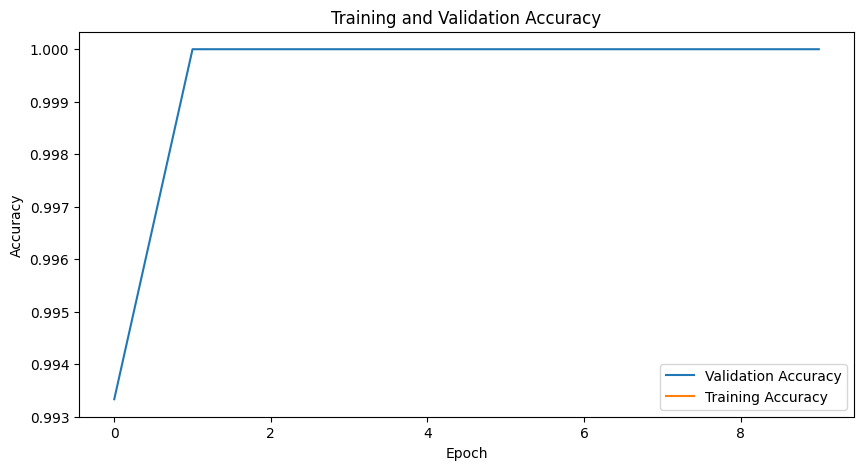

In [16]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

def plot_training_history(log_history):
       """Plots the training and validation accuracy over epochs."""

       # Extract eval_accuracy
       eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

       # Extract train_accuracy
       train_accuracy = [log['train_accuracy'] for log in log_history if 'train_accuracy' in log]

       # Create plot
       plt.figure(figsize=(10, 5))
       plt.plot(eval_accuracy, label='Validation Accuracy')
       plt.plot(train_accuracy, label='Training Accuracy')
       plt.title('Training and Validation Accuracy')
       plt.xlabel('Epoch')
       plt.ylabel('Accuracy')
       plt.legend()
       plt.show()

   # Call the plotting function with the correct history
plot_training_history(trainer.state.log_history)

In [17]:
trainer.evaluate(test_dataset)


{'eval_loss': 6.739298328284349e-07,
 'eval_accuracy': 1.0,
 'eval_runtime': 1.9314,
 'eval_samples_per_second': 77.662,
 'eval_steps_per_second': 38.831,
 'epoch': 10.0}

In [18]:
results = trainer.predict(test_dataset)
print("Test Accuracy:", results.metrics['test_accuracy'])


Test Accuracy: 1.0


In [19]:

predictions = trainer.predict(test_dataset)

logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions
predicted_labels = np.argmax(logits, axis=1)

true_labels = predictions.label_ids

# Fetch text
# test_dataset (HuggingFace Dataset) -> to_pandas() convert
df_test = test_dataset.to_pandas()

# Add label column
df_test['true_label'] = true_labels
df_test['predicted_label'] = predicted_labels

# Print N samples
sample_n = 10
print(df_test[['text', 'true_label', 'predicted_label']].sample(sample_n))


                                                  text  true_label  \
73   Subject: Offer Confirmation – UI/UX Designer a...           1   
18   Subject: Interview Decision – IT Support Speci...           0   
118  Subject: Interview Success – AI Researcher at ...           1   
78   Subject: Interview Success – Data Analyst at I...           1   
76   Subject: Interview Success – AI Researcher at ...           1   
31   Subject: Interview Success – UI/UX Designer at...           1   
64   Subject: Interview Decision – Data Analyst at ...           0   
141  Subject: Interview Decision – IT Support Speci...           0   
68   Subject: Interview Success – UI/UX Designer at...           1   
82   Subject: Interview Success – IT Support Specia...           1   

     predicted_label  
73                 1  
18                 0  
118                1  
78                 1  
76                 1  
31                 1  
64                 0  
141                0  
68                 1  

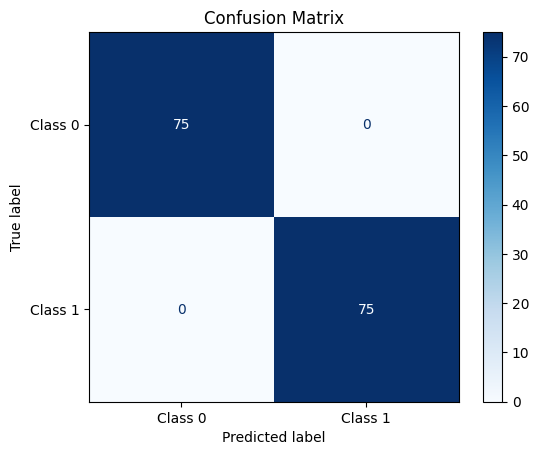

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions, axis=1)


cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Test with customized unseen data

In [21]:
import pandas as pd
from datasets import Dataset

def prepare_unseen_data_for_prediction(unseen_text, label, tokenizer):
    """
    Contert unseen data text into a format that fits into trainer.predict

    Args:
        unseen_text: unseen ata text data.
        tokenizer: tokenizer used for the model.

    Returns:
       datasets.Dataset instance that can be used for trainer.predict
    """

    label_list = [label]

    # 1. Convert text into dataframe
    data = {'text': [unseen_text]}
    df = pd.DataFrame(data)

    # 2. DataFrame -> datasets.Dataset
    dataset = Dataset.from_pandas(df)

    # 3. Preprocessing with tokenizer
    dataset = dataset.map(tokenize, batched=True)

    # 4. Add 'labels' column with true label
    dataset = dataset.add_column("labels", label_list)

    return dataset

# Input your email in text format and label here (0 = Fail, 1 = Proceed / Success)
# unseen_text ='''Dear candidate!

# We are very excited to invite you to a screening round for the role - a 30min conversation.

# If you could kindly respond to this with your preferred time for a call (times are Sydney / AEST).

# 1:00pm, Thu 24 April
# 4:00pm, Thu 24 April
# 2:00pm, Mon 28 April
# 2:30pm, Mon 28 April
# 2:00pm, Tue 29 April
# 2:30pm, Tue 29 April

# The chat will be non-technical, about getting to know you and our goals, experience. I will also spend a bit of time talking about the role and company. The invite will be for Google Meet, no other prep or materials are required.

# Thank you in advance!
# '''

unseen_text = '''
Hi,

We’re excited to invite you to the first round of interviews. This discussion will focus on the breadth of your NLP/NLG projects, including the years you completed them. If you have limited experience with NLP/NLG, you’re welcome to discuss other PyTorch projects (e.g., Computer Vision, Audio Processing, Robotics). Our goal is to cover a total of 2-4 projects.

Structure of Interview

Duration            Description

5 mins Introduction to company, analytics team, role.

25 mins              Breadth of NLP/NLG + PyTorch past projects

25 mins              Technical Discussions on selected projects

5 mins                 Questions from candidate



To make the most of our time, we will be skipping traditional ML (e.g., LightGBM/XGBoost) and Business Intelligence analysis, as they are not the primary focus of this role.


Best regards,
'''
unseen_dataset = prepare_unseen_data_for_prediction(unseen_text, 1, tokenizer)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [22]:
predictions = trainer.predict(unseen_dataset)

logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions
predicted_labels = np.argmax(logits, axis=1)

true_labels = predictions.label_ids

print("true_label:", true_labels)
print("predicted_label:", true_labels)
print("Input_text:", unseen_text)

true_label: [1]
predicted_label: [1]
Input_text: 
Hi,

We’re excited to invite you to the first round of interviews. This discussion will focus on the breadth of your NLP/NLG projects, including the years you completed them. If you have limited experience with NLP/NLG, you’re welcome to discuss other PyTorch projects (e.g., Computer Vision, Audio Processing, Robotics). Our goal is to cover a total of 2-4 projects.

Structure of Interview

Duration            Description

5 mins Introduction to company, analytics team, role.

25 mins              Breadth of NLP/NLG + PyTorch past projects

25 mins              Technical Discussions on selected projects

5 mins                 Questions from candidate



To make the most of our time, we will be skipping traditional ML (e.g., LightGBM/XGBoost) and Business Intelligence analysis, as they are not the primary focus of this role.


Best regards,



## Git Upload

In [ ]:
# !git clone

In [37]:
# !git config --global user.email "suji2000h@gmail.com"
# !git config --global user.name "SujiLee-d"


In [39]:
# # Clone your forked repo
# !git clone https://github.com/SujiLee-d/NLP_Interview_Email_Classifier.git

# # Move your .ipynb file into the cloned folder
# !mv BART_Final.ipynb NLP_Interview_Email_Classifier/

# # Go into that folder
# %cd NLP_Interview_Email_Classifier

# # Add, commit, and push
# !git add BART_Final.ipynb
# !git commit -m "BART_Final"
# !git remote set-url origin https://<TOKEN>@github.com/SujiLee-d/NLP_Interview_Email_Classifier.git
# !git push origin main



Cloning into 'NLP_Interview_Email_Classifier'...
remote: Enumerating objects: 1024, done.
remote: Counting objects: 100% (1024/1024), done.
remote: Compressing objects: 100% (756/756), done.
remote: Total 1024 (delta 268), reused 1024 (delta 268), pack-reused 0 (from 0)
Receiving objects: 100% (1024/1024), 459.87 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (268/268), done.
Updating files: 100% (1016/1016), done.
mv: cannot stat 'BART_Final.ipynb': No such file or directory
/content/drive/MyDrive/NLP_Email_Classification/NLP_Interview_Email_Classifier/NLP_Interview_Email_Classifier
git: 'BART_Final.ipynb' is not a git command. See 'git --help'.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# !git clone <<token>>@github.com/SujiLee-d/NLP_Interview_Email_Classifier.git


In [ ]:
# !pwd
# %ls

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# !cp './drive/MyDrive/Colab Notebooks/email_classification/BART_Final.ipynb' NLP_Interview_Email_Classifier/


In [ ]:
# %cd NLP_Interview_Email_Classifier
# !git add BART_Final.ipynb
# !git commit -m "BART Model_waiting for finalised dataset"
# !git push origin main
